In [26]:
#загрузим необходимые библы
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt

from tqdm.auto import tqdm

In [27]:
# Считаем дф
df = pd.read_csv('hw_aa.csv', sep=';', index_col='Unnamed: 0')

In [28]:
df

,uid,experimentVariant,version,purchase
1,c4ca4238a0b923820dcc509a6f75849b,1,v2.8.0,0
2,c81e728d9d4c2f636f067f89cc14862c,0,v2.9.0,0
3,eccbc87e4b5ce2fe28308fd9f2a7baf3,1,v2.9.0,0
4,a87ff679a2f3e71d9181a67b7542122c,1,v2.8.0,0
5,e4da3b7fbbce2345d7772b0674a318d5,1,v2.8.0,0
...,...,...,...,...
127014,d1f082ede77b17a99a9b0b240daf7bdf,0,v2.8.0,0
127015,94f0d540830ccdc6b29c1938eea445cc,0,v2.8.0,0
127016,709f74cf9721328e98be6f216e8a05a8,1,v2.9.0,0
127017,1767ae3f8ffec269d9ed0ac0ede68d90,1,v2.8.0,0


In [29]:
# Посмотрим на конверсию в разреще по версии и эксперементальной группе
df.groupby(['version', 'experimentVariant'])['purchase'].mean()

version   experimentVariant
v2.8.0    0                    0.000993
          1                    0.045606
v2.9.0    0                    0.074658
          1                    0.071304
v3.7.4.0  0                    0.059943
          1                    0.063018
v3.8.0.0  0                    0.057604
          1                    0.062848
Name: purchase, dtype: float64

Мы видим, что в версии 2.8.0 есть значимые различия в конверсии, которых быть не должно

In [19]:
df.groupby('version')['purchase'].mean()

version
v2.8.0      0.023372
v2.9.0      0.072973
v3.7.4.0    0.061484
v3.8.0.0    0.060319
Name: purchase, dtype: float64

  0%|          | 0/1000 [00:00<?, ?it/s]

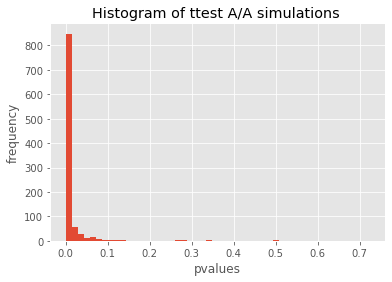

0.939

In [30]:
# Запустим аа для проверки сплит системы.
n = 100000
simulations = 1000
n_s = 1000
res = []

for i in tqdm(range(simulations)):
    s1 = df[df.experimentVariant == 1]['purchase'].sample(n_s, replace = False).values
    s2 =df[df.experimentVariant == 0]['purchase'].sample(n_s, replace = False).values
    res.append(stats.ttest_ind(s1, s2, equal_var = False)[1]) # сохраняем pvalue

plt.hist(res, bins = 50)
plt.style.use('ggplot')
plt.xlabel('pvalues')
plt.ylabel('frequency')
plt.title("Histogram of ttest A/A simulations ")
plt.show()

# Проверяем, что количество ложноположительных случаев не превышает альфа
sum(np.array(res) <0.05) / simulations

Мы видим, что FPR близок к одному, и у нас есть различия в группах. Этого быть не должно. Найдем, где ошибка. Начнем с исключения людей, которые пользовались 2.8.0, потому что там на глаз самые значимые различия по конверсии между тестовой и контрольныыми группами

  0%|          | 0/1000 [00:00<?, ?it/s]

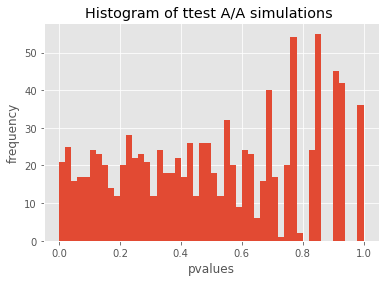

0.054

In [25]:
n = 100000
simulations = 1000
n_s = 1000
res = []

for i in tqdm(range(simulations)):
    s1 = df[(df.experimentVariant == 1) & (df.version != '2.8.0')]['purchase'].sample(n_s, replace = False).values
    s2 =df[(df.experimentVariant == 1) & (df.version != '2.8.0')]['purchase'].sample(n_s, replace = False).values
    res.append(stats.ttest_ind(s1, s2, equal_var = False)[1]) # сохраняем pvalue

plt.hist(res, bins = 50)
plt.style.use('ggplot')
plt.xlabel('pvalues')
plt.ylabel('frequency')
plt.title("Histogram of ttest A/A simulations ")
plt.show()

# Проверяем, что количество ложноположительных случаев не превышает альфа
sum(np.array(res) <0.05) / simulations

FPR равен нашему уруовню значимости, 0.05, что говорит нам о том, что в других группах эксперемента (тест/пилот) нет различий и сплит система не ошибалась работая с другими версиями прилки.